* * *
<pre> NYU Paris            <i> Machine Learning - Fall 2023 </i></pre>
* * *


<h1 align="center"> Lab: Convolutional Neural Network (CNN) </h1>

<pre align="left"> October 11th 2023               <i> Author: Guillaume Staerman </i></pre>
* * *


##### Goals:
- Code your own CNN, see the differences with MLP in term of performance and architectures

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Part 1: Build your own Convolutional Neural Network

In [41]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
torch.set_default_device('cpu')
torch.tensor([1.2, 3]).device

device(type='cpu')

## Loading and preparing the FashionMNIST dataset

In [42]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

### Question 1:

Visualize somes images of the dataset.

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


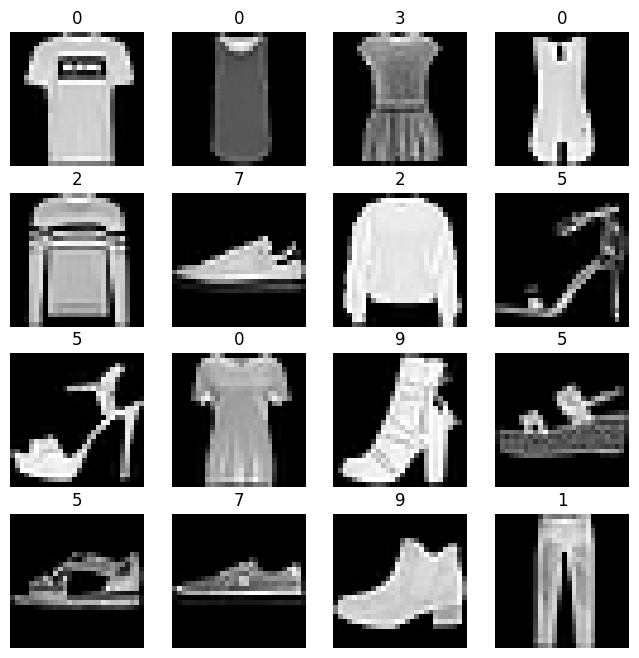

In [43]:
import matplotlib.pyplot as plt
# Visualize some images of the FashionMNIST dataset
# Size of training data
print(train_data.data.shape)

# Size of testing data
print(test_data.data.shape)

labels_map = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = i
    img, label = train_data[sample_idx][:-1][0], train_data[sample_idx][-1]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Question 2

Define a dataloader.

In [44]:
from torch.utils.data import DataLoader
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

BATCH_SIZE = 4
train_data.train_data.to(device)  # put data into GPU entirely
train_data.train_labels.to(device)
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
#generator=torch.Generator(device='cuda')

### Question 3:

Design your own Convolutional Neural Network.

In [45]:
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, \
    Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Flatten
from torch.optim import Adam, SGD
from tqdm import tqdm


In [46]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cnn_layers = Sequential(

            #first we fix a kernel
            #stride is how much you move every step
            #adds a padding so that our kernel multiplies patches on the border with more detail
            #4 is the output channel so we have 4 kernels being learned

            # Defining a 2D convolution layer with a kernel of size 3; padding 1, and stride 1.
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.Softmax2d(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # Defining another 2D convolution layer
            nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.Softmax2d(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # Define one linear layer
        self.linear_layers = Sequential(
            Flatten(),
            nn.Linear(576,10),
            nn.LogSoftmax(),
        )

    # Defining the forward pass
    def forward(self, x):
        z = self.cnn_layers(x)
        z = self.linear_layers(z)
        return z

### Question 4

Train your CNN on the training set of FashionMNIST.

In [47]:
convnet = ConvNet()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
convnet = convnet.to(device)
print(convnet.parameters)

# Optimizer
epochs = 5
learning_rate = 1e-4
optimizer = Adam(convnet.parameters(), lr=learning_rate)
# Choice of the loss
criterion = CrossEntropyLoss() # nll_loss
losses = []
convnet.train()
for t in range(epochs):
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # set optimizer to zero grad to remove previous epoch gradients
        optimizer.zero_grad()

        # Evaluate the loss
        outputs = convnet(inputs)
        loss = criterion(outputs, labels)

        # backward propagation
        loss.backward()


        # One optimization step
        optimizer.step()
        if not i % BATCH_SIZE:
            losses.append(loss.item())


        if not i % 2000:
            print(t, i, loss.item())

<bound method Module.parameters of ConvNet(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Softmax2d()
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1))
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Softmax2d()
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=576, out_features=10, bias=True)
    (2): LogSoftmax(dim=None)
  )
)>


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1941: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return handle_torch_function(log_softmax, (input,), input, dim=dim, _stacklevel=_stacklevel, dtype=dtype)


0 0 2.3593239784240723
0 2000 1.0083593130111694
0 4000 1.061142086982727
0 6000 0.5908491611480713
0 8000 0.30429327487945557
0 10000 0.49449312686920166
0 12000 0.35199567675590515
0 14000 0.3539696931838989
1 0 1.6652369499206543
1 2000 0.302715539932251
1 4000 0.4532051682472229
1 6000 0.35677045583724976
1 8000 0.0609886609017849
1 10000 0.18191470205783844
1 12000 0.2786032557487488
1 14000 0.032593052834272385
2 0 0.2024582177400589
2 2000 1.23459792137146
2 4000 0.4202222526073456
2 6000 0.24998149275779724
2 8000 1.0424675941467285
2 10000 0.056410737335681915
2 12000 0.6550431251525879
2 14000 0.12471558153629303
3 0 1.182349681854248
3 2000 0.20486266911029816
3 4000 1.143924593925476
3 6000 1.0782742500305176
3 8000 0.6271268725395203
3 10000 0.39825737476348877
3 12000 0.03648270666599274
3 14000 0.051527656614780426
4 0 0.0542297437787056
4 2000 0.27972760796546936
4 4000 0.36653631925582886
4 6000 0.49861618876457214
4 8000 0.12367580831050873
4 10000 0.06770627200603485

### Question 5

Inspect the optimization procedure through the loss.

Text(0, 0.5, 'Iterations')

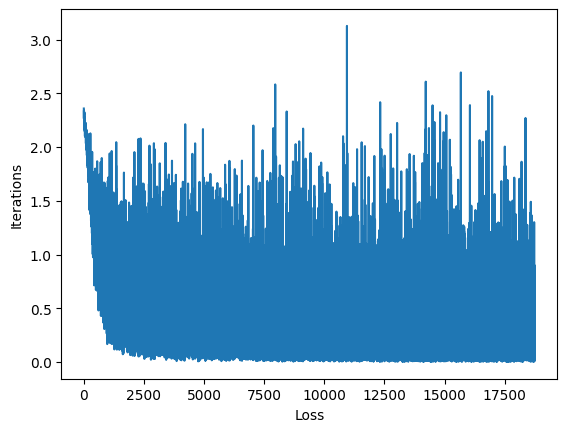

In [48]:
plt.plot(losses)
plt.xlabel("Loss")
plt.ylabel("Iterations")

The loss is very noisy because we picked a very small batch size. When we change it to 32, the loss clearly follows a decreasing fashion.

### Question 6

Quality prediction on the test set.

In [49]:
size_test = test_data.data.shape[0]
convnet.eval()
correct = 0
for data in testloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = convnet(inputs)
    loss = criterion(outputs, labels)
    predicted = torch.max(outputs.data, 1)[1]
    correct += (predicted == labels).sum()

final_accuracy =  correct/size_test

print(f"Accuracy on the test set: {final_accuracy*100}%")

Accuracy on the test set: 87.55999755859375%


### Question 7

Train the feed-forward neural network on FashionMnist and compare the accuracy of the CNN and the simple MLP.
Test it for different parameters and comment the performances.

In [50]:
BATCH_SIZE = 50
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [51]:
import torch.nn.functional as F
input_dim = 28*28
hidden_dim = 256
output_dim = 10

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.flatten(x)
        h_relu = F.relu(self.linear1(x.view(BATCH_SIZE,-1)))
        y_pred = self.linear2(h_relu)
        return y_pred

In [52]:
mlp = MLP()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
mlp = mlp.to(device)
print(mlp.parameters)

# Optimizer
epochs = 3
learning_rate = 3*1e-3
optimizer = Adam(mlp.parameters(), lr=learning_rate)
# Choice of the loss
criterion = CrossEntropyLoss() # nll_loss
losses = []
mlp.train()
for t in range(epochs):
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # set optimizer to zero grad to remove previous epoch gradients
        optimizer.zero_grad()

        # Evaluate the loss
        outputs = mlp(inputs)
        loss = criterion(outputs, labels)

        # backward propagation
        loss.backward()

        # One optimization step
        optimizer.step()
        if not i % BATCH_SIZE:
            losses.append(loss.item())

        if not i % 500:
            print(t, i, loss.item())

<bound method Module.parameters of MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=10, bias=True)
)>
0 0 2.3097546100616455
0 500 0.6112487316131592
0 1000 0.2996078431606293
1 0 0.380142480134964
1 500 0.41885435581207275
1 1000 0.3818952143192291
2 0 0.1986507773399353
2 500 0.21174846589565277
2 1000 0.5679987072944641


Text(0, 0.5, 'Iterations')

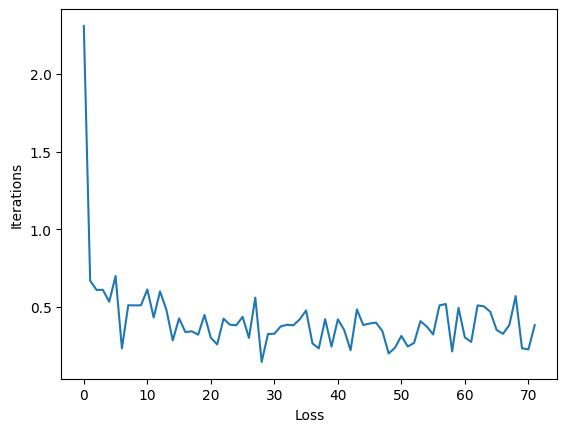

In [53]:
plt.plot(losses)
plt.xlabel("Loss")
plt.ylabel("Iterations")

In [54]:
size_test = test_data.data.shape[0]
mlp.eval()
correct = 0
for data in testloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = mlp(inputs)
    loss = criterion(outputs, labels)
    predicted = torch.max(outputs.data, 1)[1]
    correct += (predicted == labels).sum()

final_accuracy =  correct/size_test

print(f"Accuracy on the test set: {final_accuracy*100}%")

Accuracy on the test set: 87.02999877929688%


The following code repeats the previous CNN model with other parameters. Changing it a little bit gave accuracy of CNN around 90%. It is slightly better than the MLP accuracy.

In [55]:
BATCH_SIZE = 64
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [56]:
#CNN with other parameters
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cnn_layers = Sequential(

            #first we fix a kernel
            #stride is how much you move every step
            #adds a padding so that our kernel multiplies patches on the border with more detail
            #4 is the output channel so we have 4 kernels being learned

            # Defining a 2D convolution layer with a kernel of size 3; padding 1, and stride 1.
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.Softmax2d(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # Defining another 2D convolution layer
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.Softmax2d(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # Define one linear layer
        self.linear_layers = Sequential(
            Flatten(),
            nn.Linear(2304,10),
            nn.LogSoftmax(),
        )

    # Defining the forward pass
    def forward(self, x):
        z = self.cnn_layers(x)
        z = self.linear_layers(z)
        return z



convnet = ConvNet()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
convnet = convnet.to(device)
print(convnet.parameters)

# Optimizer
epochs = 2
learning_rate = 3*1e-3
optimizer = Adam(convnet.parameters(), lr=learning_rate)
# Choice of the loss
criterion = CrossEntropyLoss() # nll_loss
losses = []
convnet.train()
for t in range(epochs):
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # set optimizer to zero grad to remove previous epoch gradients
        optimizer.zero_grad()

        # Evaluate the loss
        outputs = convnet(inputs)
        loss = criterion(outputs, labels)

        # backward propagation
        loss.backward()


        # One optimization step
        optimizer.step()
        if not i % BATCH_SIZE:
            losses.append(loss.item())


        if not i % 512:
            print(t, i, loss.item())

<bound method Module.parameters of ConvNet(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Softmax2d()
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Softmax2d()
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2304, out_features=10, bias=True)
    (2): LogSoftmax(dim=None)
  )
)>
0 0 2.2977001667022705
0 512 0.2542378902435303
1 0 0.1241443082690239
1 512 0.20193496346473694


Text(0, 0.5, 'Iterations')

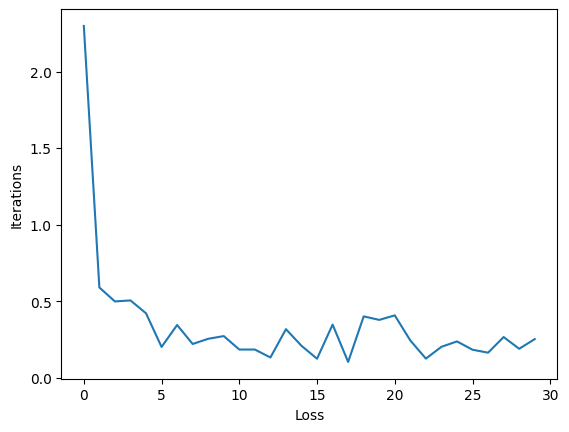

In [57]:
plt.plot(losses)
plt.xlabel("Loss")
plt.ylabel("Iterations")

In [58]:
size_test = test_data.data.shape[0]
convnet.eval()
correct = 0
for data in testloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = convnet(inputs)
    loss = criterion(outputs, labels)
    predicted = torch.max(outputs.data, 1)[1]
    correct += (predicted == labels).sum()

final_accuracy =  correct/size_test

print(f"Accuracy on the test set: {final_accuracy*100}%")

Accuracy on the test set: 89.96000671386719%


## Bonus question: Compare the computational time of MLP and CNN (with same hidden size) using the library ‘‘time''